In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd

# Load data

## Read sentence for each ALIGNED article csv file with train set and test set.

In [2]:
df_train_transcript = pd.read_csv('./CORPUS/HANJA/HANJA_TRAIN_ALL.csv')
df_train_transcript = df_train_transcript.to_dict(orient='dict')

TRAIN_KSENT = (list(df_train_transcript['KO'].values()))
TRAIN_KSENT.remove('\"')

TRAIN_ZSENT = (list(df_train_transcript['ZH'].values()))
TRAIN_ZSENT.remove('”')

TRAIN_HSENT = (list(df_train_transcript['HANJA_Z'].values()))
TRAIN_HSENT.remove('\"')

#TRAIN_HSENT = (list(df_train_transcript['HANJA_K'].values()))
#TRAIN_HSENT.remove('\"')

print(len(TRAIN_KSENT))
print(len(TRAIN_ZSENT))
print(len(TRAIN_HSENT))

df_train_transcript = []

146660
146660
146660


In [3]:
df_test_transcript = pd.read_csv('./CORPUS/HANJA/HANJA_TEST_ALL.csv')
df_test_transcript = df_test_transcript.to_dict(orient='dict')

TEST_KSENT = (list(df_test_transcript['KO'].values()))
TEST_ZSENT = (list(df_test_transcript['ZH'].values()))
TEST_HSENT = (list(df_test_transcript['HANJA_Z'].values()))
#TEST_HSENT = (list(df_test_transcript['HANJA_K'].values()))

df_test_transcript = []
print(len(TEST_KSENT))
print(len(TEST_ZSENT))
print(len(TEST_HSENT))

36089
36089
36089


In [4]:
df_train_zhuyin = pd.read_csv('./CORPUS/ZHUYIN/ZHUYIN_TRAIN_ALL.csv')
df_train_zhuyin = df_train_zhuyin.to_dict(orient='dict')

TRAIN_ZYSENT = (list(df_train_zhuyin['zhuyin'].values()))
TRAIN_ZYSENT.remove(np.nan)
TRAIN_ZYSENT = [sent.replace('\n','') for sent in TRAIN_ZYSENT]

df_train_zhuyin = []
print(len(TRAIN_ZYSENT))

146660


In [5]:
df_test_zhuyin = pd.read_csv('./CORPUS/ZHUYIN/ZHUYIN_TEST_ALL.csv')
df_test_zhuyin = df_test_zhuyin.to_dict(orient='dict')

TEST_ZYSENT = [sent.replace('\n','') for sent in (list(df_test_zhuyin['zhuyin'].values()))]

df_test_transcript = []
print(len(TEST_ZYSENT))

36089


In [6]:
print(TRAIN_ZYSENT[0])
print(TEST_ZYSENT[0])

ㄒㄧㄝˋㄒㄧㄝˋㄉㄚˋㄐㄧㄚ。
ㄨㄛˇㄒㄧㄤㄒㄧㄣˋㄖㄨˊㄍㄨㄛˇㄋㄧˇㄍㄟˇㄊㄚㄇㄣ˙ㄓㄥˋㄑㄩㄝˋㄉㄜ˙ㄈㄤㄈㄚˇㄏㄜˊㄍㄨㄥㄐㄩˋ，ㄊㄚㄇㄣ˙ㄎㄜˇㄧˇㄅㄚˇㄕㄢㄉㄡㄓㄨㄢˇㄧˊㄌㄜ˙ㄒㄧㄝˋㄒㄧㄝˋ（ㄍㄨˇㄓㄤˇㄕㄥ）


# Pretrain Model

In [7]:
import torch
from transformers import BertTokenizer, BertModel, BertConfig, BertForPreTraining, AutoModel, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertForMaskedLM
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

## Set parameters

In [8]:
# 設定訓練參數
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

max_length = 64
batch_size = 8
#batch_size = 32
learning_rate = 1e-4
num_epochs = 100

In [9]:
print(device)

cuda


## Load Tokenizer

### Chinese Tokenizer

In [10]:
zh_bert_model = AutoModel.from_pretrained('ckiplab/bert-base-chinese')

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
zh_tokenizer_all = BertTokenizer.from_pretrained('./MODELS/TOKENIZER/new_zh_tokenizer_add_bpmf_korean_tokens_v2') # load bert-base-chinese tokenizer with bpmf、hangul tokens(from 'kykim/bert-kor-base' and konlpy)
#zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
#ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
print('{}'.format(len(zh_tokenizer_all.get_vocab())))

63662


In [13]:

my_tokenizer = zh_tokenizer_all
tgt_tokenizer = zh_tokenizer_all

my_tokenizer_size = len(my_tokenizer.get_vocab())
tgt_tokenizer_size = len(tgt_tokenizer.get_vocab())

my_model = zh_bert_model
my_model.resize_token_embeddings(tgt_tokenizer_size) 
with torch.no_grad():
    my_model.embeddings.word_embeddings.weight[-1, :] = torch.zeros([my_model.config.hidden_size])


model_name = 'ZK5_zh_hanja'

### Get Embeddings

In [14]:
# 输入文本
#text = "你好，世界。 Hello, world. 안녕하세요."
#text = TRAIN_ZYSENT[0]
text = TRAIN_KSENT[0]
# 使用 mBERT 分词器对文本进行编码
inputs = my_tokenizer(text, return_tensors='pt', padding=True, truncation=True)
print(inputs)
print(my_tokenizer.decode(token_ids=inputs['input_ids'][0],skip_special_tokens=True))

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = my_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

{'input_ids': tensor([[  101, 31086,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
감사합니다.
tensor([[[-0.0689,  0.2058, -0.2094,  ...,  0.5850, -0.4557, -0.1108],
         [-0.0689,  0.2058, -0.2094,  ...,  0.5850, -0.4557, -0.1108],
         [ 0.6099,  0.7593, -1.0026,  ..., -0.0740,  0.0882,  0.1085],
         [-0.0689,  0.2058, -0.2094,  ...,  0.5850, -0.4557, -0.1108]]])


### Build Dataset Function

In [15]:
# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, bpmf_sentences, hanja_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.bpmf_sentences = bpmf_sentences
        self.hanja_sentences = hanja_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        bpmf = self.bpmf_sentences[index]
        hanja = self.hanja_sentences[index]
        return source, target, bpmf, hanja


### Build Model

In [16]:
# 建立模型
class TranslationModel(nn.Module):
    global my_tokenizer
    def __init__(self, bert_model, dropout_prob=0.1):
        super(TranslationModel, self).__init__()
        self.bert1 = bert_model
        self.bert2 = bert_model
        self.bert3 = bert_model
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(self.bert1.config.hidden_size, tgt_tokenizer_size)

    def forward(self, input_ids, bpmf_ids, hanja_ids, attention_mask, bpmf_attention_mask, hanja_attention_mask):
        zh_outputs = self.bert1(input_ids=input_ids, attention_mask=attention_mask)
        bpmf_outputs = self.bert2(input_ids=bpmf_ids, attention_mask=bpmf_attention_mask)
        hanja_outputs = self.bert3(input_ids=hanja_ids, attention_mask=hanja_attention_mask)
        
        # Apply dropout
        zh_outputs = self.dropout(zh_outputs.last_hidden_state)
        bpmf_outputs = self.dropout(bpmf_outputs.last_hidden_state)
        hanja_outputs = self.dropout(hanja_outputs.last_hidden_state)
        
        #print(zh_outputs.size())
        #print(bpmf_outputs.size())
        #print(hanja_outputs.size())
        # Combine representations
        combined_outputs = 0.5 * zh_outputs + 0.25 * bpmf_outputs + 0.25 * hanja_outputs
        
        
        prediction_scores = self.linear(combined_outputs)
        return prediction_scores


### Data Loader

In [17]:
# 載入資料集
train_source_sentences = TRAIN_ZSENT  # 中文句子
train_target_sentences = TRAIN_KSENT  # 韓文句子
dataset = TranslationDataset(train_source_sentences, train_target_sentences, TRAIN_ZYSENT, TRAIN_HSENT)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [18]:
test_source_sentences = TEST_ZSENT  # 中文句子
test_target_sentences = TEST_KSENT  # 韓文句子
test_dataset = TranslationDataset(test_source_sentences, test_target_sentences, TEST_ZYSENT, TEST_HSENT)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Model

In [19]:
# 初始化模型、損失函數和優化器
model = TranslationModel(my_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# 加載訓練好的模型
#model = TranslationModel(model_mbert).to(device)
model.load_state_dict(torch.load('./MODELS/best_translation_model({}).pth'.format(model_name)))

<All keys matched successfully>

### Train and Evaluate

In [21]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time%60)
  return elapsed_mins, elapsed_secs

In [ ]:
!pip install tqdm

In [22]:
from tqdm import tqdm

In [23]:
def train(model,path):
    global dataloader, optimizer, criterion, my_tokenizer, tgt_tokenizer
    model.train()
    total_loss = 0
    with tqdm(total = len(dataloader)) as pbar:
      for batch in dataloader:
        source_batch, target_batch , bpmf_batch , hanja_batch = batch
        source_tokens = my_tokenizer(source_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #print('src save')
        bpmf_tokens = my_tokenizer(bpmf_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #print('bpmf save')
        hanja_tokens = my_tokenizer(hanja_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #print('hanja save')
        
        target_tokens = tgt_tokenizer(target_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #print('tgt save')
            
        #print('input_ids=',source_tokens.input_ids,)
        #print('bpmf_ids=',bpmf_tokens.input_ids) 
        #print('hanja_ids=',hanja_tokens.input_ids)
        #print('target_ids',target_tokens.input_ids)
        
        #print('attention_mask=',source_tokens.attention_mask) 
        #print('bpmf_attention_mask=',bpmf_tokens.attention_mask) 
        #print('hanja_attention_mask=',hanja_tokens.attention_mask)
        
        #print(source_batch[0])
        #print('tgt_batch',len(target_batch))
        #print(bpmf_batch[0])
        #print(hanja_batch[0])
        
        #break
        optimizer.zero_grad()
        output = model(input_ids=source_tokens.input_ids, bpmf_ids=bpmf_tokens.input_ids, hanja_ids=hanja_tokens.input_ids ,attention_mask=source_tokens.attention_mask ,bpmf_attention_mask=bpmf_tokens.attention_mask , hanja_attention_mask=hanja_tokens.attention_mask)
        
        #print('olen:',output.transpose(1, 2).size(),'tgtlen',target_tokens.input_ids.size())
        
        loss = criterion(output.transpose(1, 2), target_tokens.input_ids)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.update(1)
    torch.save(model.state_dict(), path)

    return total_loss/len(dataloader)

In [24]:
def evaluate(model):
  global test_dataloader, criterion, my_tokenizer, tgt_tokenizer
  model.eval()
  total_loss = 0
  with torch.no_grad():
    with tqdm(total = len(test_dataloader)) as pbar:
      for batch in test_dataloader:
        source_batch, target_batch , bpmf_batch , hanja_batch = batch
        source_tokens = my_tokenizer(source_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        target_tokens = tgt_tokenizer(target_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        bpmf_tokens = my_tokenizer(bpmf_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        hanja_tokens = my_tokenizer(hanja_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask , bpmf_ids=bpmf_tokens.input_ids, hanja_ids=hanja_tokens.input_ids ,bpmf_attention_mask=bpmf_tokens.attention_mask , hanja_attention_mask=hanja_tokens.attention_mask)
        loss = criterion(output.transpose(1, 2), target_tokens.input_ids)

        total_loss += loss.item()
        pbar.update(1)

  return total_loss/len(test_dataloader)

In [25]:
def loss_history(train_loss_values, test_loss_values, path=model_name, to_show=False):
  before_train_loss = []
  before_test_loss = []
  try:
    df_loss = pd.read_csv('./MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(path))
    df_loss.to_dict(orient='dict')

    try:
      before_train_loss = list(df_loss['TRAIN_LOSS'].values())
      before_test_loss = list(df_loss['TEST_LOSS'].values())
    except:
      before_train_loss = list(df_loss['TRAIN_LOSS'])
      before_test_loss = list(df_loss['TEST_LOSS'])


  except:
    before_train_loss = []
    before_test_loss = []

  if(len(before_train_loss)>0):
    train_loss_values = before_train_loss + train_loss_values
    test_loss_values = before_test_loss + test_loss_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(train_loss_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, train_loss_values, 'b', label='Training loss')
  plt.plot(epochs, test_loss_values, 'r', label='Test loss')
  plt.title('Training and Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # 儲存折線圖
  plt.savefig('./MODELS/LOSS_HISTORY/loss_plot_{}.png'.format(path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'TRAIN_LOSS':train_loss_values,'TEST_LOSS':test_loss_values})
  df_loss.to_csv('./MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(path),index=False)

In [26]:
def bleu_history(bleu_score_values, path=model_name, to_show=False):
  before_bleu_score = []
  try:
    df_loss = pd.read_csv('./MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(path))
    df_loss.to_dict(orient='dict')

    try:
      before_bleu_score = list(df_loss['BLEU_SCORE'].values())
    except:
      before_bleu_score = list(df_loss['BLEU_SCORE'])


  except:
    before_bleu_score = []

  if(len(before_bleu_score)>0):
    bleu_score_values = before_bleu_score + bleu_score_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(bleu_score_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, bleu_score_values, 'b', label='BLEU score')
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('./MODELS/LOSS_HISTORY/blue_plot_{}.png'.format(path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'BLEU_SCORE':bleu_score_values})
  df_loss.to_csv('./MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(path),index=False)

In [27]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_score(model):
  global my_tokenizer, tgt_tokenizer, test_target_sentences, max_length, device
  model.eval()
  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(test_source_sentences)) as pbar:
    for source_sentence in test_source_sentences:
      source_tokens = my_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      generated_sentences.append(generated_sentence)
      pbar.update(1)


  # 計算 BLEU 分數
  smoothie = SmoothingFunction().method4
  bleu_score = corpus_bleu([[ref] for ref in test_target_sentences], generated_sentences, smoothing_function=smoothie)

  #print("BLEU 分數:", bleu_score)
  return bleu_score

In [28]:
def sacrebleu_history(bleu_score_values, path=model_name, to_show=False):
  before_avg_score = {}
  bleu_score_values = bleu_score_values[0]
  tag = ['avg','1-gram','2-gram','3-gram','4-gram']
  for key in tag:
    bleu_score_values[key] = [bleu_score_values[key]]

  try:
    df_loss = pd.read_csv('./MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(path))
    df_loss.to_dict(orient='dict')
    try:
        for key in tag:
            before_avg_score[key] = list(df_loss[key].values())
    except:
        for key in tag:
            before_avg_score[key] = list(df_loss[key])


  except:
        for key in tag:
            before_avg_score[key] = []

  if(len(before_avg_score[tag[0]])>0):
        for key in tag:
            bleu_score_values[key] = before_avg_score[key] + bleu_score_values[key]
  print(bleu_score_values)
  # 假設您有每個 epoch 的索引
  try:
      epochs = range(1, len(bleu_score_values[tag[0]]) + 1)
  except:
      epochs = range(1,2)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  for key in tag:
        try:
            plt.plot(epochs, bleu_score_values[key], label=key)
        except:
            plt.plot(epochs, list(bleu_score_values[key]), label=key)
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('./MODELS/LOSS_HISTORY/sacreblue_plot_{}.png'.format(path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame(bleu_score_values)
  df_loss.to_csv('./MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(path),index=False)
  df_loss.head()

In [29]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(model, source_sentences,target_sentences,bpmf_sentences,hanja_sentences,lang='ko'):
  global my_tokenizer, tgt_tokenizer, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        bpmf_sentence = bpmf_sentences[i]
        hanja_sentence = hanja_sentences[i]
        
        source_tokens = my_tokenizer(source_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        bpmf_tokens = my_tokenizer(bpmf_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        hanja_tokens = my_tokenizer(hanja_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, 
                           attention_mask=source_tokens.attention_mask , 
                           bpmf_ids=bpmf_tokens.input_ids, 
                           hanja_ids=hanja_tokens.input_ids ,
                           bpmf_attention_mask=bpmf_tokens.attention_mask , 
                           hanja_attention_mask=hanja_tokens.attention_mask)
        generated_sentence = tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent 
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'] += bleu_score.score      
        avg_score['1-gram'] += bleu_score.precisions[0]        
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        pbar.update(1)
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)

  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [25]:
!pip install rouge

Defaulting to user installation because normal site-packages is not writeable


In [30]:
from rouge import Rouge

def rouge_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  total_score = 0
  model.eval()
  # 生成目標語句
  generated_sentences = []
  rouge = Rouge()
  with tqdm(total = len(test_source_sentences)) as pbar:
    for i in range(len(test_source_sentences)):
      source_tokens = my_tokenizer(test_source_sentences[i], padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      try:
        scores = rouge.get_scores(generated_sentences, test_target_sentences[i])
      except:
        scores = 0
      print(generated_sentences)
      print(test_target_sentences[i])
      #print(generated_sentence)
      #for metric, score in scores.items():
      #  print(f"{metric}: {score}")
      total_score += scores
      pbar.update(1)

  avg_score = float(total_score)/len(test_source_sentences)
  print('Rouge Score:',avg_score)
  return avg_score

### Run

In [65]:
!sudo pip install --upgrade protobuf
!sudo pip install wandb
!sudo wandb login

[sudo] password for jiazhen: 


In [31]:
#best_loss = float('inf')
best_loss = 3.298
best_score = 0.0063
#best_score = 0

In [32]:
train_losses = []
test_losses = []

In [ ]:
# 訓練模型
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    bleu_scores = []

    start_time = time.time()
    train_loss = train(model, path='./MODELS/translation_model({}).pth'.format(model_name))
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #break
    print(f'Epoch {epoch+1:02} | Train Time: {epoch_mins}m {epoch_secs}s')
    #break
    start_time = time.time()
    test_loss = evaluate(model)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Test Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()
    score = sacrebleu_score(model, TEST_ZSENT,TEST_KSENT,TEST_ZYSENT,TEST_HSENT)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Eval Time: {epoch_mins}m {epoch_secs}s')

    # 儲存訓練好的模型
    #if(score['avg'] > best_score):
    if(test_loss < best_loss):
      best_score = score['avg']
      best_loss = test_loss
      torch.save(model.state_dict(), './MODELS/best_translation_model({}).pth'.format(model_name))
      print('== save model ==')
    print('\tTrain Loss: {:.3f} | Test Loss: {:.3f}'.format(train_loss, test_loss))
    print('\tBLEU Score:')
    for k in score.keys():
        print('\t\t{}: {:.3f}'.format(k,score[k]))

    if(score['avg'] < 0.001):
      try:
        model.load_state_dict(torch.load('./MODELS/best_translation_model({}).pth'.format(model_name)))
      except:
        'nothing'

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    bleu_scores.append(score)

    loss_history(train_losses, test_losses, path=model_name, to_show=False)
    sacrebleu_history(bleu_scores, path=model_name, to_show=False)

100%|█████████████████████████████████████████████████████████████████████████████| 18333/18333 [27:20<00:00, 11.18it/s]


Epoch 01 | Train Time: 27m 25s


100%|███████████████████████████████████████████████████████████████████████████████| 4512/4512 [01:59<00:00, 37.68it/s]


Epoch 01 | Test Time: 1m 59s


100%|█████████████████████████████████████████████████████████████████████████████| 36089/36089 [10:41<00:00, 56.25it/s]


Epoch 01 | Eval Time: 10m 41s
	Train Loss: 2.625 | Test Loss: 4.092
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0063183109259628, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0177512538446618, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0

100%|█████████████████████████████████████████████████████████████████████████████| 18333/18333 [27:28<00:00, 11.12it/s]


Epoch 02 | Train Time: 27m 33s


100%|███████████████████████████████████████████████████████████████████████████████| 4512/4512 [02:00<00:00, 37.57it/s]


Epoch 02 | Test Time: 2m 0s


100%|█████████████████████████████████████████████████████████████████████████████| 36089/36089 [11:00<00:00, 54.60it/s]


Epoch 02 | Eval Time: 11m 0s
	Train Loss: 2.621 | Test Loss: 4.907
	BLEU Score:
		avg: 0.006
		1-gram: 0.016
		2-gram: 0.008
		3-gram: 0.004
		4-gram: 0.002
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0063183109259628, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454005], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0177512538446618, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

100%|█████████████████████████████████████████████████████████████████████████████| 18333/18333 [27:28<00:00, 11.12it/s]


Epoch 03 | Train Time: 27m 33s


100%|███████████████████████████████████████████████████████████████████████████████| 4512/4512 [02:00<00:00, 37.31it/s]


Epoch 03 | Test Time: 2m 0s


100%|█████████████████████████████████████████████████████████████████████████████| 36089/36089 [10:44<00:00, 56.01it/s]


Epoch 03 | Eval Time: 10m 44s
	Train Loss: 2.620 | Test Loss: 4.302
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0063183109259628, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0177512538446618, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

100%|█████████████████████████████████████████████████████████████████████████████| 18333/18333 [27:27<00:00, 11.12it/s]


Epoch 04 | Train Time: 27m 32s


100%|███████████████████████████████████████████████████████████████████████████████| 4512/4512 [01:58<00:00, 38.06it/s]


Epoch 04 | Test Time: 1m 58s


100%|█████████████████████████████████████████████████████████████████████████████| 36089/36089 [10:31<00:00, 57.16it/s]


Epoch 04 | Eval Time: 10m 31s
	Train Loss: 2.621 | Test Loss: 3.604
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0063183109259628, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0177512538446618, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0

100%|█████████████████████████████████████████████████████████████████████████████| 18333/18333 [27:27<00:00, 11.13it/s]


Epoch 05 | Train Time: 27m 32s


100%|███████████████████████████████████████████████████████████████████████████████| 4512/4512 [02:00<00:00, 37.54it/s]


Epoch 05 | Test Time: 2m 0s


100%|█████████████████████████████████████████████████████████████████████████████| 36089/36089 [10:44<00:00, 56.03it/s]


Epoch 05 | Eval Time: 10m 44s
	Train Loss: 2.621 | Test Loss: 4.029
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0063183109259628, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0177512538446618, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0

100%|█████████████████████████████████████████████████████████████████████████████| 18333/18333 [27:30<00:00, 11.11it/s]


Epoch 06 | Train Time: 27m 35s


100%|███████████████████████████████████████████████████████████████████████████████| 4512/4512 [01:59<00:00, 37.79it/s]


Epoch 06 | Test Time: 1m 59s


100%|█████████████████████████████████████████████████████████████████████████████| 36089/36089 [10:41<00:00, 56.23it/s]


Epoch 06 | Eval Time: 10m 41s
	Train Loss: 2.621 | Test Loss: 3.578
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0063183109259628, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0056438069113454, 0.0, 0.0, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0177512538446618, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0155864667904347, 0.0, 0.0, 0.0, 0

 85%|█████████████████████████████████████████████████████████████████▍           | 15576/18333 [23:22<04:07, 11.14it/s]

In [ ]:
bleu_score(test_source_sentences,model,tokenizer,max_length,device)

In [53]:

score = sacrebleu_score(TEST_ZSENT,TEST_KSENT,TEST_ZYSENT,TEST_HSENT)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36089/36089 [08:24<00:00, 71.56it/s]


In [58]:
print('\tBLEU Score:')
for k in score.keys():
    print('\t\t{}: {:.3f}'.format(k,score[k]))


	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000


{'avg': [0.0, 0.01, 0.03], '1-gram': [0.0, 0.01, 0.04], '2-gram': [0.0, 0.01, 0.03], '3-gram': [0.0, 0.01, 0.02], '4-gram': [0.0, 0.01, 0.01]}


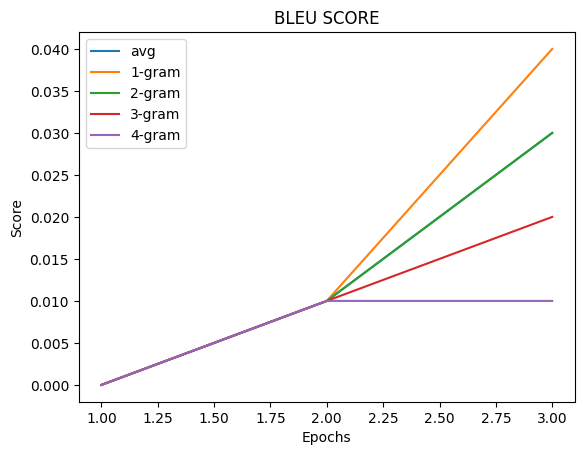

In [83]:
test_score = {'avg': 0.03, '1-gram': 0.04, '2-gram': 0.03, '3-gram': 0.02, '4-gram': 0.01}
sacrebleu_history([test_score])

In [ ]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(source_sentences,target_sentences,lang='ko'):
  global zh_tokenizer, ko_tokenizer, model, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        source_tokens = zh_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        generated_sentence = ko_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent 
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'] += bleu_score.score      
        avg_score['1-gram'] += bleu_score.precisions[0]        
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        pbar.update(1)
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)

  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [ ]:
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)